# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape) #여기서 y_train은 숫자로 표현되어 있다. 0~9값을 가지는.
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
#np.nonzero(np.ravel(a))[0] 과 동일 0이아닌 값의 index를 반환한다. 
#np.ravel() Return a contiguous flattened array. A 1-D array, containing the elements of the input, is returned. A copy is made only if needed.

# of plane: 5000
# of car: 5000
# of bird: 5000
# of cat: 5000
# of deer: 5000
# of dog: 5000
# of frog: 5000
# of horse: 5000
# of ship: 5000
# of truck: 5000


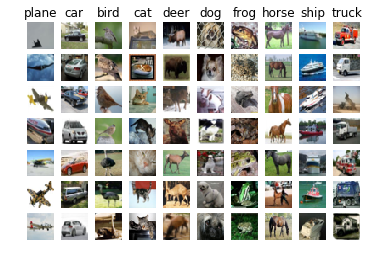

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes): #0,'plane' / 1,'car' / ... / 9,'truck'
    idxs = np.flatnonzero(y_train == y) #y_train중에서 0 즉, 'plane'인것을 추출해서 idxs 나열 
    print('# of '+ cls +': '+ str(len(idxs)))
    idxs = np.random.choice(idxs, samples_per_class, replace=False) #해당 idxs (약 5000개 중에서) 7개를 랜덤하게 뽑는다.
    # print(idxs) 각각의 클래스에 대해서 추출하는지 확인
    for i, idx in enumerate(idxs): # 0,1382 / 1,49510 / ... / 6,30172
        plt_idx = i * num_classes + y + 1 # 0*10+0+1 / 1*10+0+1 / 2*10+0+1 / ... / 6*10+0+1 : 비행기 열
                                          # 0*10+1+1 / 1*10+1+1 / ...            / 6*10+1+1 : 자동차 열
        plt.subplot(samples_per_class, num_classes, plt_idx) # 7 by 10 matrix , 열 별로 plt_idx를 부여하나 보다. 1 ~ 70 
        plt.imshow(X_train[idx].astype('uint8')) 
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [22]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
#print(mask)
X_train = X_train[mask] # 1/10만 추출, 
y_train = y_train[mask]

for y, cls in enumerate(classes): #0,'plane' / 1,'car' / ... / 9,'truck'
    idxs = np.flatnonzero(y_train == y) #y_train중에서 0 즉, 'plane'인것을 추출해서 idxs 나열 
    print('# of '+ cls +': '+ str(len(idxs)))
    
num_test = 500
mask = list(range(num_test))
X_test = X_test[mask] # 1/20만 추출
y_test = y_test[mask]

# of plane: 505
# of car: 460
# of bird: 519
# of cat: 486
# of deer: 519
# of dog: 488
# of frog: 519
# of horse: 486
# of ship: 520
# of truck: 498


In [6]:
# tips
a = np.arange(12)

print(a.reshape(3,-1))
print(a.reshape(2,2,-1))
print(a.reshape(2,-1,2))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]
[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]]


In [7]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) #X_train.shape (50000,32,32,3)
X_test = np.reshape(X_test, (X_test.shape[0], -1))
#print(X_train.shape, X_test.shape)
#print(y_train.shape)
#print(X_train[3].shape)
#print(X_test[0,:].shape)
#print(pow((X_train[0] - X_test[0]),2).shape)

In [8]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor() # 객체를 생성
classifier.train(X_train, y_train) # train 데이터를 내부 변수로 넣는다. 


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [9]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test) # 매소드 호출, self.X_train 과 X를 가지고 계산을 한다. 
print(dists.shape)

(500, 5000)


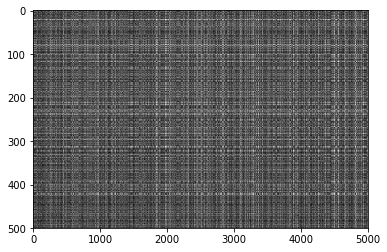

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
fig = plt.figure()
plt.imshow(dists, interpolation='none', aspect='auto')
plt.show()
#fig.savefig('knn_image.png')

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
  : black - similar object , white - not similar object
- What causes the columns?
  : 하나의 트레인 데이터랑 일치하는 테스트 데이터500개 
  
열, 행으로 줄이 나타나는 것을 볼때 왜 특정 Test이미지가 다수의 Train이미지와 거리가 먼것일까?


In [11]:
print(np.shape(np.sum(np.abs(X_train - X_test[0,:]),axis=1)))

(5000,)


In [12]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
# test 행 0~499와 5000개 train을 계산해서 거리가 가장 유사한 X_train의 idx를 구한다. ('0',plain의 경우 505개가 존재하는데 이 중 하나일 수도 있다.) 
# 해당 idx의 y값을 저장한다.(1개) 당연 이상적이라면 plane이 걸여야 한다. 
#print(np.shape(y_test_pred))

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [13]:
# 주변을 조금 더 살피고(?) y값을 정한다. 
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also use other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*: 
(1)(3)  
*Your explanation*:
L1 거리를 사용하는 NN 분류기는 데이터를 평균으로 빼주었을 때에도 퍼포먼스가 동일하다.(1)
데이터의 축이 회전 되었을 때에도 동일하다.(3)
왜냐하면 데이터간의 거리를 바탕으로 분류를 하기 때문이다. 

하지만 정규화까지 진행해 버리면(2) 데이터간의 거리가 변동이 되어 distance값이 변동되어 퍼포먼스가 달라지지 않을까 하는게 내 추측이다.

In [14]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)
#print(dists_one.shape)
# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [15]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time) #왜 one loop가 시간이 더 걸릴까??

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 36.487369 seconds
One loop version took 52.358816 seconds
No loop version took 0.302173 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [20]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# Your code
X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)

#테스트 횟수는 val데이터수와 같다.(1000)
#num_test = X_train.shape[0] / num_folds 

#X_train_folds = X_train[:4000,:]
#X_val = X_train[4000:,:]
#y_train_folds = y_train[0:4000]
#y_val = y_train[4000:]
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.

# cross-validation 수행 후, k_to_accuracies[k]는 해당 k를 사용했을 때에 따른 정확도 값을 제공하는
# num_folds길이의(?) 리스트여야 한다. 
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# Knn을 num_folds 수 만큼 수행하라, 모든 fold와 k_to_accuracies 사전의 모든 k 관해 정확도를 저장하라. 
#print( np.vstack(X_train_folds[0:1]).shape) #(1000,3072)
#print( np.vstack(X_train_folds[0:1] + X_train_folds[1+1:]).shape) #(4000,3072)
        
for k in k_choices:
    # 각각의 k에 대해서 나눈 등분수(5) 만큼 조사, 그리고 평균을 낸다.
    k_to_accuracies[k] = []
    for i in range(num_folds): # 0, 1, 2, 3, 4
        # 5번에 걸쳐, 새롭게 X_train_cv 와 y_train_cv를 정의
        X_train_cv = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_train_cv = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        
        X_val_cv = X_train_folds[i] #i번째 등분이 val set이 된다.
        y_val_cv = y_train_folds[i]
        
        classifier.train(X_train_cv, y_train_cv)
        #X_train_folds를 데이터로 사용하고, X_val로 라벨을 예상한 후
        dists_two = classifier.compute_distances_no_loops(X_val_cv) 
        #각각의 k일 때 예측한 y_val_predict를 반환한다.
        y_val_predict = classifier.predict_labels(dists_two,k) 
        #num_correct = np.sum(y_val_predict == y_val_cv) 
        #accuracy = float(num_correct) / num_test
        acc = np.mean(y_val_predict == y_val_cv) #각각의 맞는 정도를 반환하여 최적의 k값을 찾아본다.
        k_to_accuracies[k].append(acc)
        #k_to_accuracies.update({k : acc})
        #k_to_accuracies.append((k,acc))
    
print(k_to_accuracies)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


{1: [0.263, 0.257, 0.264, 0.278, 0.266], 3: [0.239, 0.249, 0.24, 0.266, 0.254], 5: [0.248, 0.266, 0.28, 0.292, 0.28], 8: [0.262, 0.282, 0.273, 0.29, 0.273], 10: [0.265, 0.296, 0.276, 0.284, 0.28], 12: [0.26, 0.295, 0.279, 0.283, 0.28], 15: [0.252, 0.289, 0.278, 0.282, 0.274], 20: [0.27, 0.279, 0.279, 0.282, 0.285], 50: [0.271, 0.288, 0.278, 0.269, 0.266], 100: [0.256, 0.27, 0.263, 0.256, 0.263]}
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 1

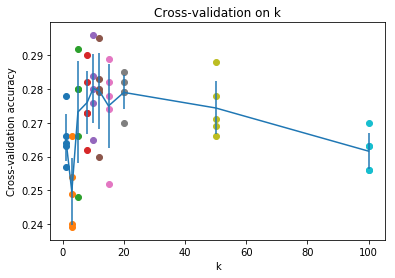

In [21]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
#plt.axis([0,101,0.24,0.29])
plt.show()

In [23]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k, num_loops=0)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.(O)  
- K가 1일때 보다 5일때가 데이터 수가 많을 경우 더 분류기로 적합하지 않을 까. 하지만 카테고리 수도 고려해야 할것 이다.
  
2. The test error of a 1-NN will always be better than that of a 5-NN.
- 

3. The decision boundary of the k-NN classifier is linear.(X)  

4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.(O)  
- 트레이닝 데이터 사이즈가 커지면 test 이미지를 분류하는데 시간이 더 들어간다. 비교군이 늘어나기 때문이다.  

5. None of the above.

*Your Answer*:  
*Your explanation*:

In [24]:
for i in range(1,100):
    classifier = KNearestNeighbor()
    classifier.train(X_train, y_train)
    y_test_pred = classifier.predict(X_test, k=i)
    # Compute and display the accuracy
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / y_test.shape[0]
    print('Got %d / %d correct => accuracy: %f ( k=%d )' % (num_correct, num_test, accuracy, i))

Got 137 / 500 correct => accuracy: 0.274000 ( k=1 )
Got 112 / 500 correct => accuracy: 0.224000 ( k=2 )
Got 136 / 500 correct => accuracy: 0.272000 ( k=3 )
Got 136 / 500 correct => accuracy: 0.272000 ( k=4 )
Got 139 / 500 correct => accuracy: 0.278000 ( k=5 )
Got 141 / 500 correct => accuracy: 0.282000 ( k=6 )
Got 137 / 500 correct => accuracy: 0.274000 ( k=7 )
Got 137 / 500 correct => accuracy: 0.274000 ( k=8 )
Got 134 / 500 correct => accuracy: 0.268000 ( k=9 )
Got 141 / 500 correct => accuracy: 0.282000 ( k=10 )
Got 131 / 500 correct => accuracy: 0.262000 ( k=11 )
Got 128 / 500 correct => accuracy: 0.256000 ( k=12 )
Got 133 / 500 correct => accuracy: 0.266000 ( k=13 )
Got 136 / 500 correct => accuracy: 0.272000 ( k=14 )
Got 136 / 500 correct => accuracy: 0.272000 ( k=15 )
Got 134 / 500 correct => accuracy: 0.268000 ( k=16 )
Got 134 / 500 correct => accuracy: 0.268000 ( k=17 )
Got 133 / 500 correct => accuracy: 0.266000 ( k=18 )
Got 135 / 500 correct => accuracy: 0.270000 ( k=19 )
Go

https://github.com/kingtaurus/cs231n/blob/master/assignment1/knn.ipynb(값이 조금 이상하다)

https://github.com/huyouare/CS231n/blob/master/assignment1/cs231n/classifiers/k_nearest_neighbor.py

https://github.com/huyouare/CS231n/blob/master/assignment1/cs231n/classifiers/k_nearest_neighbor.py